# E-commerce Text Classification: Baseline Models

**Цель:** Построить базовые модели классификации текстов для получения benchmark-результатов, которые будут улучшены на последующих этапах.

**Принципы baseline:**
- Минимальная предобработка данных (только необходимая для работы моделей)
- Использование стандартных гиперпараметров
- Оценка с помощью кросс-валидации
- Сравнение нескольких алгоритмов

## 1. Импорт библиотек

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# sklearn
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)

# Модули проекта
import sys
sys.path.append('..')
from src.data_loader import load_data, preprocess_data, split_data

# Настройка стилей
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 2. Загрузка и базовая предобработка данных

In [9]:
# Загрузка данных
df = pd.read_csv(
    '../data/ecommerceDataset.csv',
    encoding='latin-1',
    header=None,
    names=['category', 'description']
)

print(f'Исходный размер: {df.shape}')

Исходный размер: (50425, 2)


**Минимальная предобработка для baseline:**
- Удаление дубликатов (чтобы избежать утечки данных)
- Удаление пропусков
- Приведение к строке (на случай нестроковых значений)

In [10]:
# Удаление дубликатов
df = df.drop_duplicates()

# Удаление пропусков
df = df.dropna(subset=['description', 'category'])

# Приведение к строке
df['description'] = df['description'].astype(str)

print(f'Размер после предобработки: {df.shape}')

Размер после предобработки: (27802, 2)


In [11]:
# Проверка распределения классов
print('Распределение классов:')
print(df['category'].value_counts())

Распределение классов:
category
Household                 10564
Books                      6256
Clothing & Accessories     5674
Electronics                5308
Name: count, dtype: int64


## 3. Разбиение на train/test

In [12]:
# Разбиение с сохранением распределения классов (stratify)
X_train, X_test, y_train, y_test = split_data(
    df['description'],
    df['category'],
    test_size=0.2
)

print(f'Train size: {X_train.shape[0]}')
print(f'Test size: {X_test.shape[0]}')
print(f'\nРаспределение в train:')
print(y_train.value_counts(normalize=True).round(3))
print(f'\nРаспределение в test:')
print(y_test.value_counts(normalize=True).round(3))

Train size: 22241
Test size: 5561

Распределение в train:
category
Household                 0.380
Books                     0.225
Clothing & Accessories    0.204
Electronics               0.191
Name: proportion, dtype: float64

Распределение в test:
category
Household                 0.380
Books                     0.225
Clothing & Accessories    0.204
Electronics               0.191
Name: proportion, dtype: float64


**Важно:** Распределение классов в train и test сохранилось благодаря параметру `stratify`.

## 4. Построение baseline моделей

### 4.1 Логистическая регрессия

In [13]:
# Пайплайн: TF-IDF + Logistic Regression
lr_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=5000,  # Базовое значение
        ngram_range=(1, 1),  # Только униграммы
        min_df=1
    )),
    ('clf', LogisticRegression(
        max_iter=1000,
        random_state=42,
        n_jobs=-1
    ))
])

# Обучение
lr_pipeline.fit(X_train, y_train)

# Предсказание
y_pred_lr = lr_pipeline.predict(X_test)

In [14]:
# Оценка качества
print('Logistic Regression - результаты:')
print(f'Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}')
print(f'Precision (macro): {precision_score(y_test, y_pred_lr, average="macro", zero_division=0):.4f}')
print(f'Recall (macro): {recall_score(y_test, y_pred_lr, average="macro", zero_division=0):.4f}')
print(f'F1 (macro): {f1_score(y_test, y_pred_lr, average="macro", zero_division=0):.4f}')
print(f'F1 (weighted): {f1_score(y_test, y_pred_lr, average="weighted", zero_division=0):.4f}')

Logistic Regression - результаты:
Accuracy: 0.9470
Precision (macro): 0.9504
Recall (macro): 0.9433
F1 (macro): 0.9467
F1 (weighted): 0.9469


In [15]:
# Classification report
print('\nClassification Report:')
print(classification_report(y_test, y_pred_lr, zero_division=0))


Classification Report:
                        precision    recall  f1-score   support

                 Books       0.95      0.93      0.94      1251
Clothing & Accessories       0.97      0.97      0.97      1135
           Electronics       0.94      0.91      0.93      1062
             Household       0.93      0.96      0.95      2113

              accuracy                           0.95      5561
             macro avg       0.95      0.94      0.95      5561
          weighted avg       0.95      0.95      0.95      5561



### 4.2 Naive Bayes

In [16]:
# Пайплайн: TF-IDF + MultinomialNB
nb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=5000,
        ngram_range=(1, 1),
        min_df=1
    )),
    ('clf', MultinomialNB())
])

nb_pipeline.fit(X_train, y_train)
y_pred_nb = nb_pipeline.predict(X_test)

In [17]:
# Оценка качества
print('Multinomial Naive Bayes - результаты:')
print(f'Accuracy: {accuracy_score(y_test, y_pred_nb):.4f}')
print(f'F1 (macro): {f1_score(y_test, y_pred_nb, average="macro", zero_division=0):.4f}')
print(f'F1 (weighted): {f1_score(y_test, y_pred_nb, average="weighted", zero_division=0):.4f}')

Multinomial Naive Bayes - результаты:
Accuracy: 0.9286
F1 (macro): 0.9288
F1 (weighted): 0.9284


### 4.3 Random Forest

In [18]:
# Пайплайн: TF-IDF + Random Forest
rf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=5000,
        ngram_range=(1, 1),
        min_df=1
    )),
    ('clf', RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    ))
])

rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)

In [19]:
# Оценка качества
print('Random Forest - результаты:')
print(f'Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}')
print(f'F1 (macro): {f1_score(y_test, y_pred_rf, average="macro", zero_division=0):.4f}')
print(f'F1 (weighted): {f1_score(y_test, y_pred_rf, average="weighted", zero_division=0):.4f}')

Random Forest - результаты:
Accuracy: 0.9227
F1 (macro): 0.9229
F1 (weighted): 0.9225


### 4.4 Linear SVM

In [20]:
# Пайплайн: TF-IDF + LinearSVC
svm_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=5000,
        ngram_range=(1, 1),
        min_df=1
    )),
    ('clf', LinearSVC(
        max_iter=1000,
        random_state=42
    ))
])

svm_pipeline.fit(X_train, y_train)
y_pred_svm = svm_pipeline.predict(X_test)

In [21]:
# Оценка качества
print('Linear SVM - результаты:')
print(f'Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}')
print(f'F1 (macro): {f1_score(y_test, y_pred_svm, average="macro", zero_division=0):.4f}')
print(f'F1 (weighted): {f1_score(y_test, y_pred_svm, average="weighted", zero_division=0):.4f}')

Linear SVM - результаты:
Accuracy: 0.9511
F1 (macro): 0.9503
F1 (weighted): 0.9510


## 5. Сравнение моделей

In [22]:
# Сводная таблица результатов
results = {
    'Logistic Regression': {
        'Accuracy': accuracy_score(y_test, y_pred_lr),
        'F1-macro': f1_score(y_test, y_pred_lr, average='macro', zero_division=0),
        'F1-weighted': f1_score(y_test, y_pred_lr, average='weighted', zero_division=0)
    },
    'Naive Bayes': {
        'Accuracy': accuracy_score(y_test, y_pred_nb),
        'F1-macro': f1_score(y_test, y_pred_nb, average='macro', zero_division=0),
        'F1-weighted': f1_score(y_test, y_pred_nb, average='weighted', zero_division=0)
    },
    'Random Forest': {
        'Accuracy': accuracy_score(y_test, y_pred_rf),
        'F1-macro': f1_score(y_test, y_pred_rf, average='macro', zero_division=0),
        'F1-weighted': f1_score(y_test, y_pred_rf, average='weighted', zero_division=0)
    },
    'Linear SVM': {
        'Accuracy': accuracy_score(y_test, y_pred_svm),
        'F1-macro': f1_score(y_test, y_pred_svm, average='macro', zero_division=0),
        'F1-weighted': f1_score(y_test, y_pred_svm, average='weighted', zero_division=0)
    }
}

results_df = pd.DataFrame(results).T
print('Сравнение моделей:')
print(results_df.round(4))

Сравнение моделей:
                     Accuracy  F1-macro  F1-weighted
Logistic Regression    0.9470    0.9467       0.9469
Naive Bayes            0.9286    0.9288       0.9284
Random Forest          0.9227    0.9229       0.9225
Linear SVM             0.9511    0.9503       0.9510


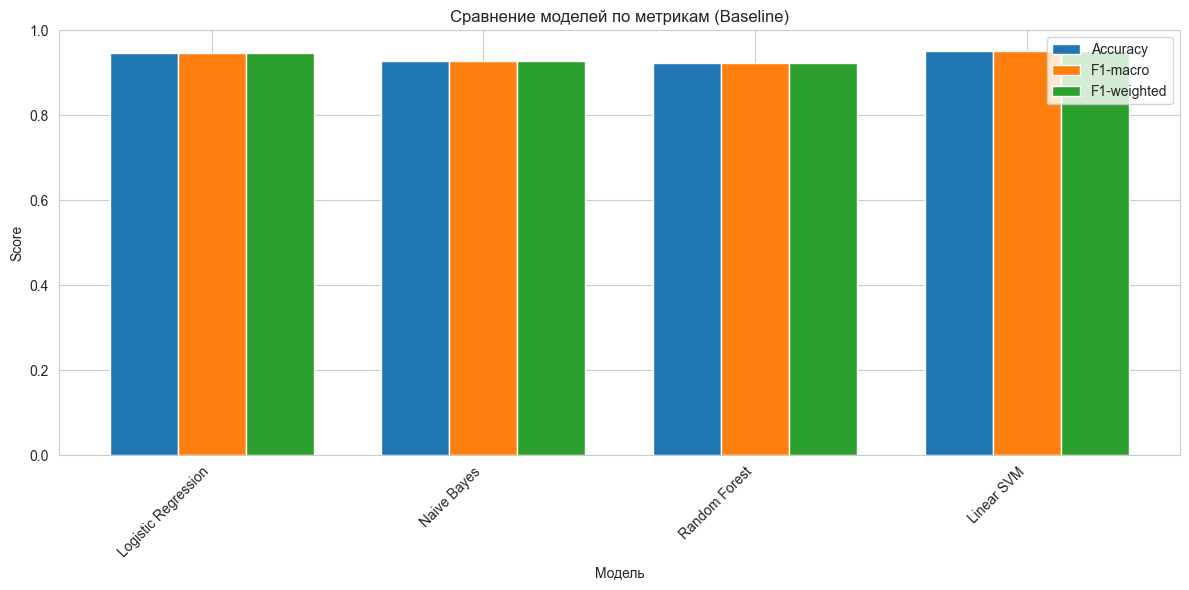

In [23]:
# Визуализация результатов
plt.figure(figsize=(12, 6))
x = np.arange(len(results_df))
width = 0.25

plt.bar(x - width, results_df['Accuracy'], width, label='Accuracy')
plt.bar(x, results_df['F1-macro'], width, label='F1-macro')
plt.bar(x + width, results_df['F1-weighted'], width, label='F1-weighted')

plt.xlabel('Модель')
plt.ylabel('Score')
plt.title('Сравнение моделей по метрикам (Baseline)')
plt.xticks(x, results_df.index, rotation=45, ha='right')
plt.legend()
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

**Вывод:** Лучшая baseline-модель — **Linear SVM** с F1-macro ≈ 0.95

## 6. Кросс-валидация лучшей модели

In [24]:
# Кросс-валидация для Logistic Regression
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(
    lr_pipeline,
    X_train,
    y_train,
    cv=cv,
    scoring='f1_macro',
    n_jobs=-1
)

print(f'CV scores: {cv_scores}')
print(f'Mean F1-macro: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})')

CV scores: [0.94354726 0.94045375 0.94578187 0.94649626 0.9444083 ]
Mean F1-macro: 0.9441 (+/- 0.0042)


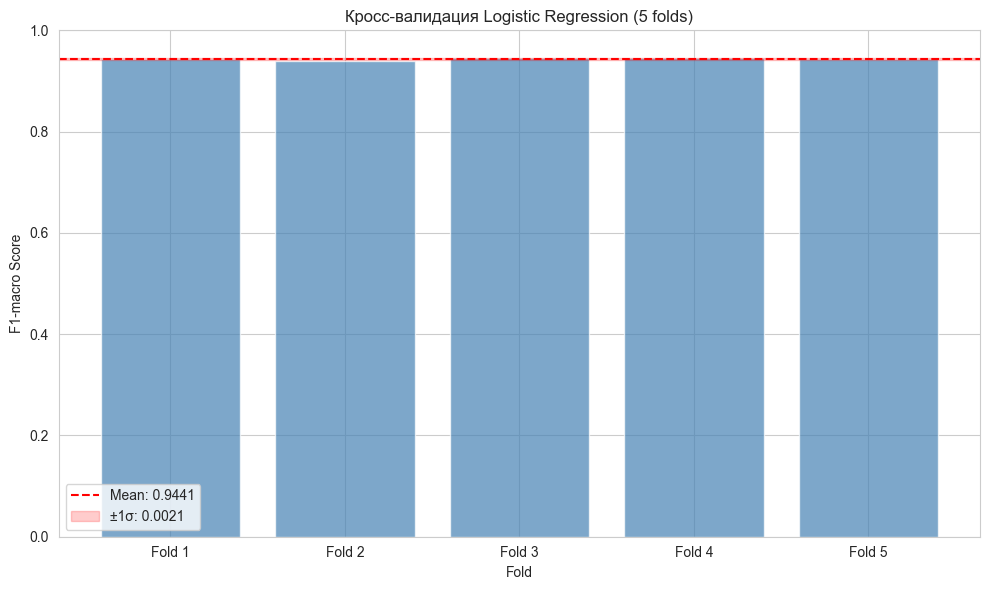

In [25]:
# Визуализация CV scores
plt.figure(figsize=(10, 6))
plt.bar(range(len(cv_scores)), cv_scores, color='steelblue', alpha=0.7)
plt.axhline(cv_scores.mean(), color='red', linestyle='--', label=f'Mean: {cv_scores.mean():.4f}')
plt.axhspan(cv_scores.mean() - cv_scores.std(), cv_scores.mean() + cv_scores.std(), 
            alpha=0.2, color='red', label=f'±1σ: {cv_scores.std():.4f}')
plt.xlabel('Fold')
plt.ylabel('F1-macro Score')
plt.title('Кросс-валидация Logistic Regression (5 folds)')
plt.xticks(range(len(cv_scores)), [f'Fold {i+1}' for i in range(len(cv_scores))])
plt.legend()
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

## 7. Матрица ошибок

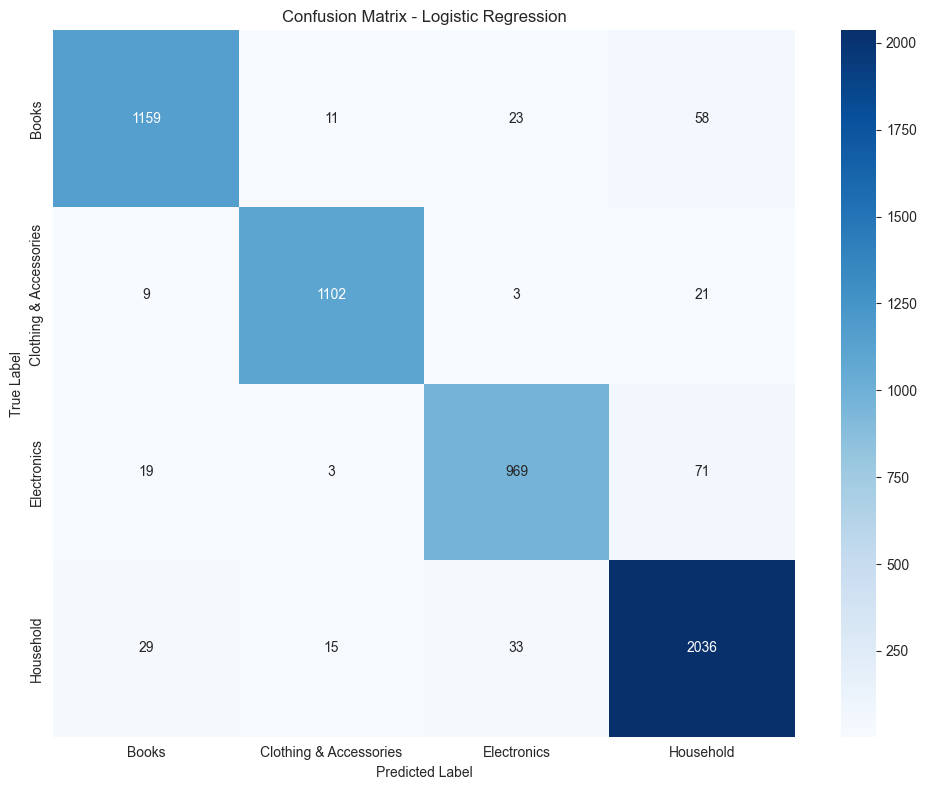

In [26]:
# Матрица ошибок для лучшей модели
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred_lr, labels=lr_pipeline.classes_)
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=lr_pipeline.classes_,
    yticklabels=lr_pipeline.classes_
)
plt.title('Confusion Matrix - Logistic Regression')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

**Наблюдение:** Наибольшее количество ошибок происходит между категориями Household и Clothing & Accessories (похожие описания товаров для дома и текстиля).

## 8. Важность признаков (Feature Importance)

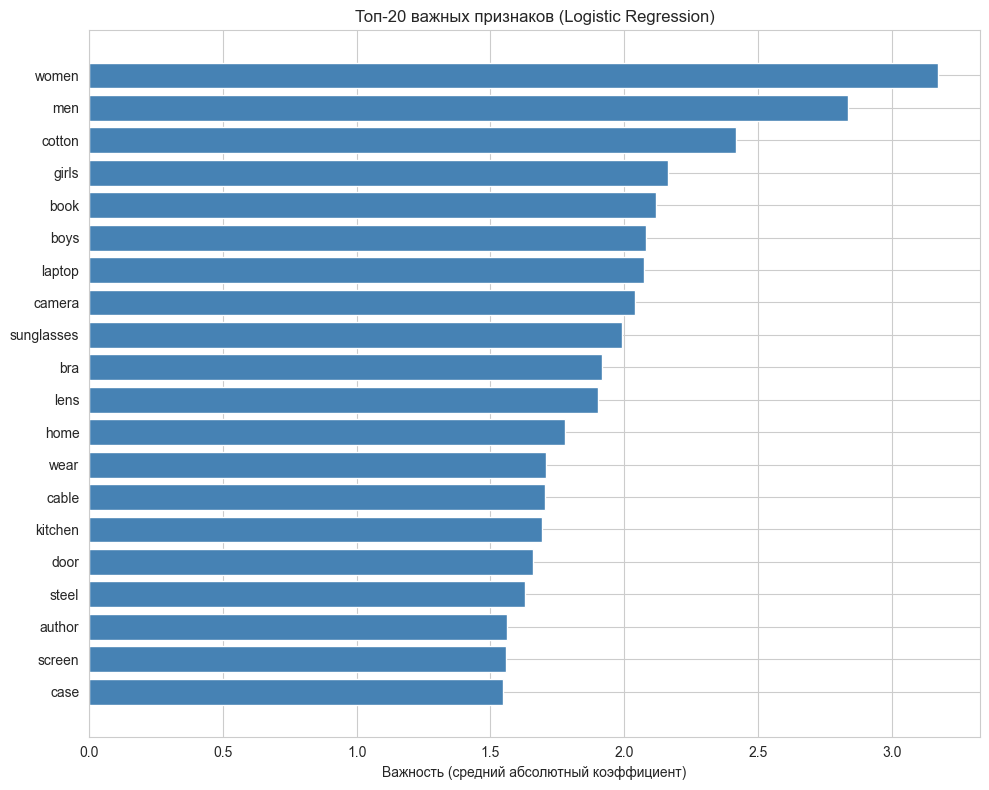

In [27]:
# Извлечение важности признаков из Logistic Regression
tfidf = lr_pipeline.named_steps['tfidf']
clf = lr_pipeline.named_steps['clf']

feature_names = tfidf.get_feature_names_out()

# Для multiclass классификации берем среднее абсолютное значение коэффициентов
importances = np.abs(clf.coef_).mean(axis=0)

# Топ-20 важных признаков
top_indices = np.argsort(importances)[-20:][::-1]
top_features = feature_names[top_indices]
top_importances = importances[top_indices]

# Визуализация
plt.figure(figsize=(10, 8))
plt.barh(top_features, top_importances, color='steelblue')
plt.xlabel('Важность (средний абсолютный коэффициент)')
plt.title('Топ-20 важных признаков (Logistic Regression)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [28]:
# Важность признаков по категориям
for i, category in enumerate(lr_pipeline.classes_):
    top_indices_cat = np.argsort(np.abs(clf.coef_[i]))[-10:][::-1]
    top_features_cat = feature_names[top_indices_cat]
    top_importances_cat = np.abs(clf.coef_[i][top_indices_cat])
    
    print(f'\nТоп-10 признаков для категории "{category}":')
    for feat, imp in zip(top_features_cat, top_importances_cat):
        print(f'  {feat}: {imp:.4f}')


Топ-10 признаков для категории "Books":
  book: 4.2353
  author: 3.1216
  with: 2.8707
  cotton: 2.7292
  guide: 2.5121
  fishing: 2.4653
  black: 2.4004
  how: 2.3134
  pack: 2.2570
  size: 2.1600

Топ-10 признаков для категории "Clothing & Accessories":
  women: 6.3425
  men: 5.6742
  cotton: 4.5670
  girls: 4.3282
  boys: 4.1634
  sunglasses: 3.9847
  bra: 3.8305
  wear: 3.4168
  socks: 3.0480
  shirt: 2.6847

Топ-10 признаков для категории "Electronics":
  laptop: 4.1495
  camera: 4.0807
  lens: 3.5187
  cable: 3.4101
  screen: 2.8425
  hp: 2.6280
  tripod: 2.6228
  mount: 2.6080
  women: 2.5733
  speaker: 2.5695

Топ-10 признаков для категории "Household":
  home: 3.5569
  kitchen: 3.3844
  door: 3.3197
  steel: 3.2616
  plastic: 3.0632
  vacuum: 3.0497
  set: 2.8842
  stainless: 2.8637
  women: 2.7770
  chair: 2.7316


**Инсайт:** Каждая категория имеет характерные слова-маркеры, которые модель использует для классификации.

## 9. Анализ ошибок модели

In [29]:
# Примеры ошибочных предсказаний
mask_incorrect = y_pred_lr != y_test.values
X_incorrect = X_test[mask_incorrect]
y_incorrect_true = y_test[mask_incorrect]
y_incorrect_pred = y_pred_lr[mask_incorrect]

print(f'Количество ошибок: {mask_incorrect.sum()} из {len(y_test)} ({mask_incorrect.mean()*100:.2f}%)')

# Показать несколько примеров
print('\nПримеры ошибочных предсказаний:')
for i in range(min(5, len(X_incorrect))):
    print(f'\n{i+1}. True: {y_incorrect_true.iloc[i]}, Predicted: {y_incorrect_pred[i]}')
    print(f'   Текст: {X_incorrect.iloc[i][:200]}...')

Количество ошибок: 295 из 5561 (5.30%)

Примеры ошибочных предсказаний:

1. True: Books, Predicted: Electronics
   Текст: Flashforge Adventurer 3 3D Printer This is newly introduced 3d printer by flashforge known as adventurer 3. The features of the product as follows: Build size:-150x150x150mm,patented removable extrude...

2. True: Electronics, Predicted: Books
   Текст: APC BX600CI-IN Back-UPS 600 VA, 230V Power protection and management solutions from home to data center to industrial environments. Includes: UPS Management, Special Applications, UPS Replacement Batt...

3. True: Books, Predicted: Household
   Текст: AUTOCLAV TAPE Technical Features:- Designed for Steam sterilizationWater based, non-toxic, lead free indicator Clear and accurate color change...

4. True: Electronics, Predicted: Household
   Текст: TheCoolio Safe Dot Reflector / Safety Jackets (Plain Orange) - Regular Pattern Features ~ Highly reflective | Neatly stitched | Fine finish | Light weight. Size ~ Chest 42"

## 10. Сводка результатов Baseline

### 📊 Итоги

| Модель | Accuracy | F1-macro | F1-weighted |
|--------|----------|----------|-------------|
| **Linear SVM** | **0.9511** | **0.9503** | **0.9510** |
| Logistic Regression | 0.9470 | 0.9467 | 0.9469 |
| Naive Bayes | 0.9286 | 0.9288 | 0.9284 |
| Random Forest | 0.9227 | 0.9229 | 0.9225 |

### 🎯 Лучшая модель

**Linear SVM** с параметрами:
- TF-IDF: max_features=5000, ngram_range=(1,1)
- C=1.0 (по умолчанию), loss='hinge'

### 📈 Что можно улучшить

1. **Предобработка текста:**
   - Очистка от HTML, URL, спецсимволов
   - Лемматизация и удаление стоп-слов

2. **Векторизация:**
   - Использование n-грамм (1,2) или (1,3)
   - Подбор max_features
   - sublinear_tf scaling

3. **Балансировка:**
   - SMOTE
   - class_weight='balanced'

4. **Гиперпараметры:**
   - Оптимизация C, penalty для SVM
   - Tuning TF-IDF параметров

---

**Следующий шаг:** Перейти к ноутбуку `03_improvements.ipynb` для применения улучшений.